#**Sales Prediction (Maven Sales Challenge)**

##This is an extension of the Maven Sales Dashboard Challenge project. Using data that resembles real-world company sales provided by Maven, models--Regression, SARIMA, LSTM-- was built to predict the company's close values and sales.

## **Data Cleanup (check for null values, duplicates, etc)**


In [1]:
import zipfile
with zipfile.ZipFile('CRM+Sales+Opportunities.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

In [2]:
import pandas as pd

df_accounts = pd.read_csv('/content/accounts.csv')
df_products = pd.read_csv('/content/products.csv')
df_sales_teams = pd.read_csv('/content/sales_teams.csv')
df_sales_pipeline = pd.read_csv('/content/sales_pipeline.csv')


In [3]:
df_sales_pipeline.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_date', 'close_date', 'close_value'],
      dtype='object')

In [4]:
df_sales_pipeline['product'].replace('GTXPro', 'GTX Pro', inplace = True)

In [5]:
df_sales_pipeline[df_sales_pipeline['product'] == 'GTX Pro']

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0
11,KWVA7VR1,Gladys Colclough,GTX Pro,Genco Pura Olive Oil Company,Lost,2016-11-04,2017-03-18,0.0
18,902REDPA,Daniell Hammack,GTX Pro,Xx-zobam,Lost,2016-11-07,2017-03-09,0.0
29,KNY1OSAB,Maureen Marcano,GTX Pro,Labdrill,Won,2016-11-11,2017-03-14,4899.0
32,JYKM0B00,James Ascencio,GTX Pro,Xx-holding,Won,2016-11-12,2017-03-06,4338.0
...,...,...,...,...,...,...,...,...
8661,SAUIIUTV,Marty Freudenburg,GTX Pro,NaN,Prospecting,NaN,NaN,NaN
8662,B5H6M7AP,Marty Freudenburg,GTX Pro,NaN,Prospecting,NaN,NaN,NaN
8732,G4B3UCWQ,Niesha Huffines,GTX Pro,NaN,Prospecting,NaN,NaN,NaN
8733,8O212QCV,Niesha Huffines,GTX Pro,NaN,Prospecting,NaN,NaN,NaN


In [6]:
df_sales_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opportunity_id  8800 non-null   object 
 1   sales_agent     8800 non-null   object 
 2   product         8800 non-null   object 
 3   account         7375 non-null   object 
 4   deal_stage      8800 non-null   object 
 5   engage_date     8300 non-null   object 
 6   close_date      6711 non-null   object 
 7   close_value     6711 non-null   float64
dtypes: float64(1), object(7)
memory usage: 550.1+ KB


In [7]:
df_sales_pipeline['account'].fillna('No Account', inplace = True)
df_sales_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opportunity_id  8800 non-null   object 
 1   sales_agent     8800 non-null   object 
 2   product         8800 non-null   object 
 3   account         8800 non-null   object 
 4   deal_stage      8800 non-null   object 
 5   engage_date     8300 non-null   object 
 6   close_date      6711 non-null   object 
 7   close_value     6711 non-null   float64
dtypes: float64(1), object(7)
memory usage: 550.1+ KB


In [8]:
#ensure correct data types
df_sales_pipeline['engage_date'] = pd.to_datetime(df_sales_pipeline['engage_date'])
df_sales_pipeline['close_date'] = pd.to_datetime(df_sales_pipeline['close_date'])

In [9]:
filtered_df_sales_pipeline=df_sales_pipeline[df_sales_pipeline['close_value'].notnull()].copy()

In [10]:
filtered_df_sales_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6711 entries, 0 to 8299
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   opportunity_id  6711 non-null   object        
 1   sales_agent     6711 non-null   object        
 2   product         6711 non-null   object        
 3   account         6711 non-null   object        
 4   deal_stage      6711 non-null   object        
 5   engage_date     6711 non-null   datetime64[ns]
 6   close_date      6711 non-null   datetime64[ns]
 7   close_value     6711 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 471.9+ KB


In [11]:
#No duplicated rows
filtered_df_sales_pipeline[filtered_df_sales_pipeline.duplicated()]

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value


## **Predicting close value of each sales with Regression Model**

In [12]:
#Feature Engineering

filtered_df_sales_pipeline['engage_month'] = filtered_df_sales_pipeline['engage_date'].dt.month
filtered_df_sales_pipeline['engage_day'] = filtered_df_sales_pipeline['engage_date'].dt.day
filtered_df_sales_pipeline['close_month'] = filtered_df_sales_pipeline['close_date'].dt.month
filtered_df_sales_pipeline['close_day'] = filtered_df_sales_pipeline['close_date'].dt.day
filtered_df_sales_pipeline['deal_duration'] = (filtered_df_sales_pipeline['close_date'] - filtered_df_sales_pipeline['engage_date']).dt.days

In [13]:
#Encode categorical variables
filtered_df_sales_pipeline = pd.get_dummies(filtered_df_sales_pipeline, columns = ['sales_agent', 'product', 'account','deal_stage'], drop_first = True)
filtered_df_sales_pipeline.head()


,opportunity_id,engage_date,close_date,close_value,engage_month,engage_day,close_month,close_day,deal_duration,sales_agent_Boris Faz,...,account_Xx-zobam,account_Y-corporation,account_Yearin,account_Zathunicon,account_Zencorporation,account_Zoomit,account_Zotware,account_Zumgoity,account_dambase,deal_stage_Won
0,1C1I7A6R,2016-10-20,2017-03-01,1054.0,10,20,3,1,132,False,...,False,False,False,False,False,False,False,False,False,True
1,Z063OYW0,2016-10-25,2017-03-11,4514.0,10,25,3,11,137,False,...,False,False,False,False,False,False,False,False,False,True
2,EC4QE1BX,2016-10-25,2017-03-07,50.0,10,25,3,7,133,False,...,False,False,False,False,False,False,False,False,False,True
3,MV1LWRNH,2016-10-25,2017-03-09,588.0,10,25,3,9,135,False,...,False,False,False,False,False,False,False,False,False,True
4,PE84CX4O,2016-10-25,2017-03-02,517.0,10,25,3,2,128,False,...,False,False,False,False,False,False,False,False,False,True


In [14]:
# Normalize/standardize numerical features:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
filtered_df_sales_pipeline[['deal_duration', 'engage_month', 'engage_day', 'close_month', 'close_day', 'close_value']] = scaler.fit_transform(filtered_df_sales_pipeline[['deal_duration','engage_month','engage_day','close_month','close_day','close_value']])



In [15]:
#Handling outliers
# Removing rows which contains outliers (standard deviation far from mean)
from scipy import stats
import numpy as np

# Exclude timestamp columns
numeric_cols = filtered_df_sales_pipeline.select_dtypes(include = [np.number])

# Apply zscore to numeric columns only
z_scores = np.abs(stats.zscore(numeric_cols))

# Filter the original Dataframe based on z-scores, keeping the timestamp columns
filtered_df_sales_pipeline = filtered_df_sales_pipeline[(z_scores < 3).all(axis=1)]

In [16]:
from sklearn.preprocessing import PolynomialFeatures
# Polynomial features
# Feature engineering to capture non-linear relationships
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(filtered_df_sales_pipeline.drop(['opportunity_id', 'engage_date', 'close_date', 'close_value'], axis = 1))
y = filtered_df_sales_pipeline['close_value']

In [17]:
#split data
from sklearn.model_selection import train_test_split

# seed number 42
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

In [18]:
from sklearn.linear_model import Ridge, Lasso
# train model with Ridge & lasso regression
# Ridge include regularization term (L2 norm) in the cost function to prevent overfitting
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train, y_train)
lasso = Lasso(alpha = 1.0)
lasso.fit(X_train, y_train)

Lasso()

In [19]:
#predict and evaluate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Ridge R2 Score: {r2}')
print(f'Ridge MSE: {mse}')

scores = cross_val_score(ridge, X_poly, y, cv = 5)
print("Cross-validated Ridge R2 Score: " + str(scores.mean()))

y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Lasso R2 Score: {r2}')
print(f'Lasso MSE: {mse}')

scores = cross_val_score(lasso, X_poly, y, cv = 5)
print("Cross-validated Lasso R1 Score: " + str(scores.mean()))

Ridge R2 Score: 0.9762728670925712
Ridge MSE: 0.017765461930575408
Cross-validated Ridge R2 Score: 0.9775254629604326
Lasso R2 Score: -4.3662682789769036e-05
Lasso MSE: 0.7487730476167992
Cross-validated Lasso R1 Score: -0.0058850225443507044


In [20]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv = 5)
grid.fit(X_train, y_train)
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)
y_pred = grid.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Ridge R-square: ", str(r2))
print("Ridge MSE: " + str(mse))

grid = GridSearchCV(Lasso(), param_grid, cv = 5)
grid.fit(X_train, y_train)
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)
y_pred = grid.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Lasso R-squared: ", r2)
print("Lasso MSE: ", mse)

Best alpha: 10
Ridge R-square:  0.979808539860077
Ridge MSE: 0.015118161045333199
Best alpha: 0.001
Lasso R-squared:  0.983699837309643
Lasso MSE:  0.012204589609183553


In [21]:
# Ensemble methods
# construct 100 decision tree and averaging the prediction of all trees
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-square: ", str(r2))
print("MSE: ", str(mse))


R-square:  0.9823415518388245
MSE:  0.013221592755616109


### **Conclusion:**
### Lasso regression gave the best results with R-squared = 0.9837 and MSE = 0.0122. This shows that the model does a well job in learning & predicting the close value of sales based on existing data. But generally, regression models are less capable in predicting data that have a temporal or seasonal patterns unless the feature engineering to create the pattern was done. Therefore, other models that are capable of doing so, such as SARIMA & LSTM, should be built to have an even better prediction

##**SARIMA**

In [22]:
# Preparing for SARIMA model (1)

df_sales_pipeline['close_date'] = pd.to_datetime(df_sales_pipeline['close_date'])

# Aggregate Data by Month
# Set 'close_date' as the index
df = df_sales_pipeline.set_index('close_date').copy()

#Resample to monthly frequency and sum 'close_value'
monthly_df_sales_pipeline = df['close_value'].resample('M').sum()

# Reset index to have 'close_date' as a column again
monthly_df_sales_pipeline = monthly_df_sales_pipeline.reset_index()
monthly_df_sales_pipeline

,close_date,close_value
0,2017-03-31,1134672.0
1,2017-04-30,721932.0
2,2017-05-31,1025713.0
3,2017-06-30,1338466.0
4,2017-07-31,696932.0
5,2017-08-31,1050059.0
6,2017-09-30,1235264.0
7,2017-10-31,731980.0
8,2017-11-30,938943.0
9,2017-12-31,1131573.0


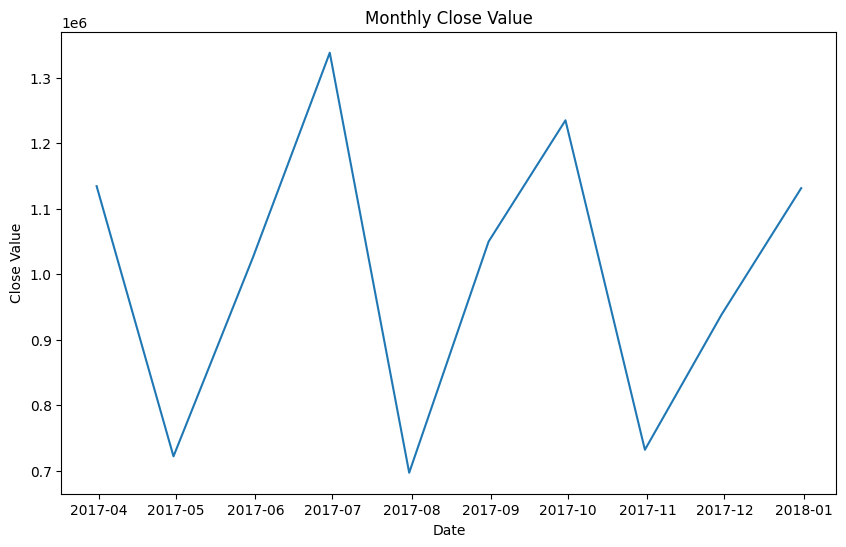

ADF Statistic: 1.0735221403988684
p-value: 0.9949841875987036


In [23]:
# Preparing for SARIMA model (2)
# check for stationary

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

#plot the time series
plt.figure(figsize = (10, 6))
plt.plot(monthly_df_sales_pipeline['close_date'], monthly_df_sales_pipeline['close_value'])
plt.title('Monthly Close Value')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.show()

# Perform ADF test for stationarity
result = adfuller(monthly_df_sales_pipeline['close_value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [24]:
monthly_df_sales_pipeline['diff'] = monthly_df_sales_pipeline['close_value'].diff().dropna()

#check if differenced series is stationary

result_diff = adfuller(monthly_df_sales_pipeline['diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (difference): {result_diff[1]}')

ADF Statistic (Differenced): -10.961241791763344
p-value (difference): 8.315901770412593e-20


In [25]:
import statsmodels.api as sm

# Define the SARIMA model

model = sm.tsa.SARIMAX(monthly_df_sales_pipeline['close_value'],
                       order = (1,1,1), # p, d, q
                       seasonal_order = (1,1,1,12), # P, D, Q, s
                       enforce_stationarity = False,
                       enforce_invertibility = False)

# fit the model

results = model.fit()

# Print model summary
# print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


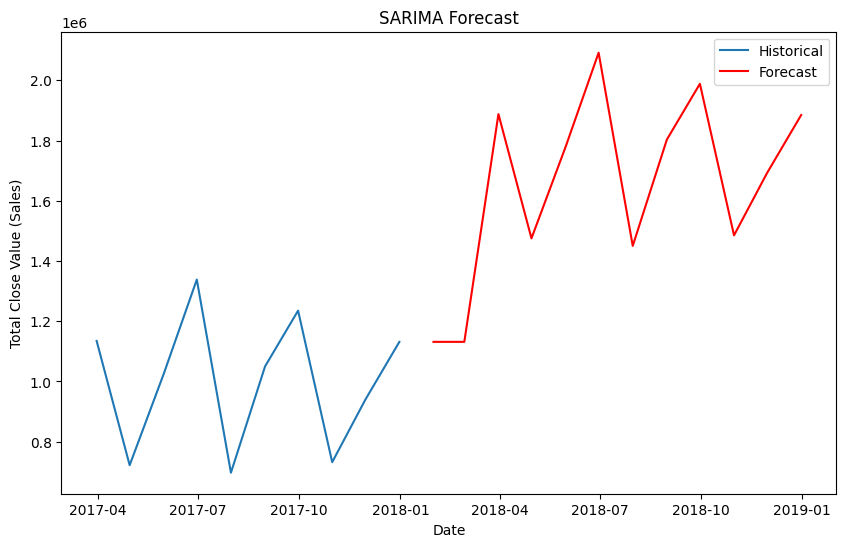

In [26]:
# Forecast the next 12 months
forecast = results.get_forecast(steps = 12)
forecast_index = pd.date_range(start=monthly_df_sales_pipeline['close_date'].max() + pd.DateOffset(months =1 ), periods =12, freq = 'M')
forecast_values = forecast.predicted_mean

# Plot the results
plt.figure(figsize = (10, 6))
plt.plot(monthly_df_sales_pipeline['close_date'], monthly_df_sales_pipeline['close_value'], label = 'Historical')
plt.plot(forecast_index, forecast_values, label = 'Forecast' , color = 'red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Total Close Value (Sales)')
plt.legend()
plt.show()

### **Conclusion:**
### The Maven data that was provided does not have a wide timerange. This posed a difficulty in using SARIMA to predict monthly sales due to the limited timerange. The prediction, as you can see evidently far from accurate due the to the huge jump in the sales that did not make sense.

##**LSTM model**

In [30]:
# LSTM forecast

df = df_sales_pipeline.set_index('close_date').copy()

monthly_data = df['close_value'].resample('M').sum()

monthly_data = monthly_data.reset_index()

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3183 - val_loss: 0.4823
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3003 - val_loss: 0.4719
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2884 - val_loss: 0.4617
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2799 - val_loss: 0.4516
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2672 - val_loss: 0.4416
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2612 - val_loss: 0.4317
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2456 - val_loss: 0.4212
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2349 - val_loss: 0.4104
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2246 - val_loss: 0.3995
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2115 - val_loss: 0.3883
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1972 - val_loss: 0.3769
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1886 - val_loss: 0.3652

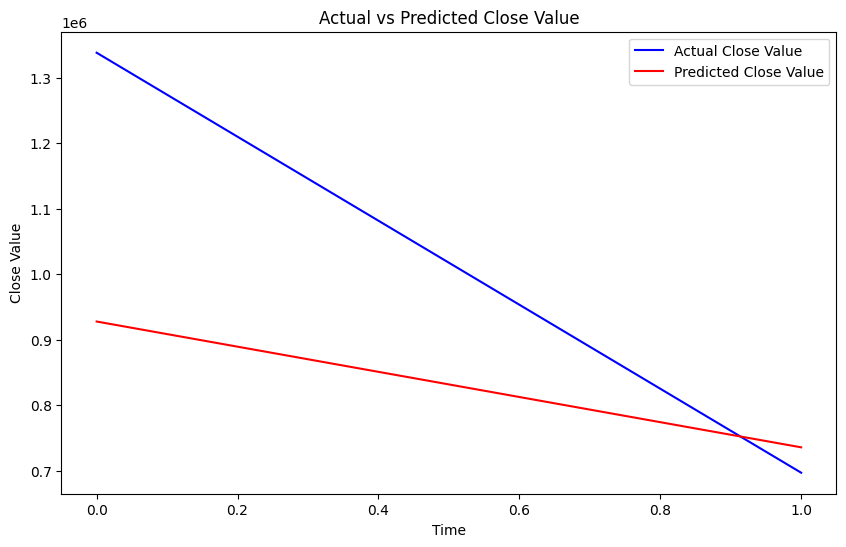

Mean Squared Error: 85036346861.93164
R-squared: 0.17353354679434807


In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
# Initialize the scaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(monthly_data[['close_value']])

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3

X,y = create_sequences(scaled_data, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Define The LSTM model
model = Sequential()

batch_size = 8
epochs = 200
# Add the LSTM layer
model.add(LSTM(units=64,
               return_sequences = True,
               input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(32))

model.add(Dropout(0.1))

model.add(Dense(32,activation='relu') )

# Add the output layer
model.add(Dense(1))


#compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, y_test), verbose = 1)

# Make prediction
predicted_values = model.predict(X_test)

# Inverse the normalization to get actual values
predicted_values = scaler.inverse_transform(predicted_values)
y_test_actual = scaler.inverse_transform(y_test)

# Visualize
#plot actual vs predicted values
plt.figure(figsize = (10,6))
plt.plot(y_test_actual, color= 'blue', label = 'Actual Close Value')
plt.plot(predicted_values, color='red', label = 'Predicted Close Value')
plt.title('Actual vs Predicted Close Value')
plt.xlabel('Time')
plt.ylabel('Close Value')
plt.legend()
plt.show()

#calculate performance metrics

mse = mean_squared_error(y_test_actual, predicted_values)
r2 = r2_score(y_test_actual, predicted_values)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')





### **Conclusion:**
### Further experimentation on sequence length, batch size, number of LSTM layers and units, number of Dense layers and units, and dropout value need to be done as the current Mean Squared Error and R-squared error scores leaves much to be desired.